In [112]:
# extracting the compessed Dataset
from zipfile import ZipFile
dataset = '/content/face-mask-dataset.zip'

with ZipFile(dataset,'r') as zip:
  zip.extractall()
  print('The dataset is extracted')

The dataset is extracted


**Importing the Dependencies**

In [113]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.utils import custom_object_scope
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

import numpy as np
import matplotlib.pyplot as plt
import cv2
from google.colab.patches import cv2_imshow
import os

In [114]:
data_dir = '/content/data/'
img_height = 128
img_width = 128
batch_size = 32

In [115]:
# Create the training dataset (80% of the data)
# It automatically finds the classes ('with_mask', 'without_mask') and labels them
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,  # Use 20% for validation
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size
)

Found 7553 files belonging to 2 classes.
Using 6043 files for training.


In [116]:
# Create the validation dataset (the other 20%)
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size
)

Found 7553 files belonging to 2 classes.
Using 1510 files for validation.


In [117]:
# See the classes it found (0 = without_mask, 1 = with_mask, or vice-versa)
class_names = train_ds.class_names
print("Classes found:", class_names)

Classes found: ['with_mask', 'without_mask']


Configure Dataset for Performance

In [118]:
# .cache() keeps images in memory after they're loaded
# .shuffle() randomizes the data
# .prefetch() overlaps data preprocessing and model execution
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
print("Datasets configured for performance.")

Datasets configured for performance.


Define the Model (with Transfer Learning)

In [119]:
IMG_SHAPE = (img_height, img_width, 3)

# 1. Load the pre-trained base model
base_model = MobileNetV2(
    input_shape=IMG_SHAPE,
    include_top=False,  # We don't want its original classifier
    weights='imagenet'  # Use the weights it learned from ImageNet
)

In [120]:
# 2. Freeze the base model (we don't want to re-train its weights)
base_model.trainable = False

In [121]:
# 3. Create our Data Augmentation layers
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

In [122]:
# 4. Build our new model
inputs = tf.keras.Input(shape=IMG_SHAPE)

In [123]:
# Augment the data
x = data_augmentation(inputs)

In [124]:
# Preprocess the data for MobileNetV2 (scales pixels from 0-255 to -1 to 1)
x = preprocess_input(x)

In [125]:
# Run the base model
x = base_model(x, training=False)

In [126]:
# Add our own classifier head
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.5)(x)

In [127]:
# Final output layer (1 neuron, sigmoid for binary classification)
outputs = layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(inputs, outputs)

In [128]:
### Compile the Model
model.compile(optimizer='adam',
              loss='binary_crossentropy', # Best loss for binary (0/1) classification
              metrics=['accuracy'])

model.summary()

Model: "functional_39"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_3 (Sequential)       │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide_2 (TrueDivide)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract_2 (Subtract)           │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_128            │ (None, 4, 4, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Train the Model

In [129]:
# Use EarlyStopping to automatically stop training when the model is no longer improving.

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

epochs = 20

history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[early_stopping]
)

Epoch 1/20
189/189 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.8970 - loss: 0.2480 - val_accuracy: 0.9834 - val_loss: 0.0445
Epoch 2/20
189/189 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - accuracy: 0.9735 - loss: 0.0817 - val_accuracy: 0.9848 - val_loss: 0.0423
Epoch 3/20
189/189 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.9758 - loss: 0.0658 - val_accuracy: 0.9868 - val_loss: 0.0421
Epoch 4/20
189/189 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - accuracy: 0.9793 - loss: 0.0590 - val_accuracy: 0.9861 - val_loss: 0.0377
Epoch 5/20
189/189 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - accuracy: 0.9793 - loss: 0.0585 - val_accuracy: 0.9894 - val_loss: 0.0347
Epoch 6/20
189/189 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - accuracy: 0.9830 - loss: 0.0537 - val_accuracy: 0.9881 - val_loss: 0.0321
Epoch 7/20
189/189 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.9805 - loss: 0.0524 - val_accuracy: 0.9854 - val_loss: 0.0412
Epoch 8/20
189/189 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - accuracy: 0.9835 - loss: 0.0449 - val_a

Save New Model

In [130]:
model.save('face_mask_mobilenet.keras')

Plot Training Results

In [131]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_ran = range(len(acc))

plt.figure(figsize=(12, 5))

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

Plot Accuracy

Text(0.5, 1.0, 'Training and Validation Accuracy')

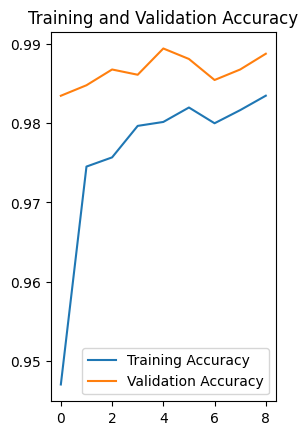

In [132]:
plt.subplot(1, 2, 1)
plt.plot(epochs_ran, acc, label='Training Accuracy')
plt.plot(epochs_ran, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

Plot Loss

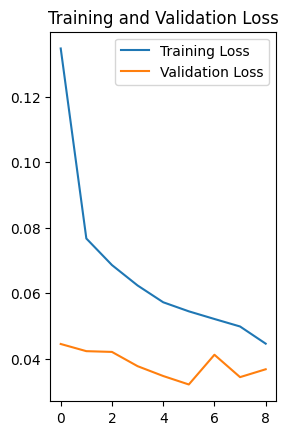

In [133]:
plt.subplot(1, 2, 2)
plt.plot(epochs_ran, loss, label='Training Loss')
plt.plot(epochs_ran, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

Setup for Real-World Prediction

In [134]:
# Download the Haar Cascade file
!wget https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_default.xml

--2025-11-14 18:34:15--  https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_default.xml
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 930127 (908K) [text/plain]
Saving to: ‘haarcascade_frontalface_default.xml’

haarcascade_frontal 100%[===================>] 908.33K  --.-KB/s    in 0.03s   

2025-11-14 18:34:15 (28.7 MB/s) - ‘haarcascade_frontalface_default.xml’ saved [930127/930127]



In [135]:
# Reload the model (good practice to test the saved file)
with custom_object_scope({'preprocess_input': preprocess_input}):
    model = load_model('face_mask_mobilenet.keras', compile=False)

face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

In [136]:
def predict_mask_on_image(image_path, face_cascade, model, class_names):

    # Define colors (BGR)
    RED = (0, 0, 255)
    GREEN = (0, 255, 0)

    frame = cv2.imread(image_path)
    if frame is None:
        print(f"Error: Could not load image from {image_path}")
        return

    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.1, 4)

    print(f"Found {len(faces)} faces.")

    for (x, y, w, h) in faces:

        # 1. Crop the face
        face_crop = frame[y:y+h, x:x+w]

        # 2. Preprocess the cropped face (MUST match training)
        face_rgb = cv2.cvtColor(face_crop, cv2.COLOR_BGR2RGB) # Model wants RGB
        face_resized = cv2.resize(face_rgb, (128, 128))

        # 3. Reshape for the model
        face_reshaped = np.reshape(face_resized, [1, 128, 128, 3])

        # 4. IMPORTANT: We DO NOT preprocess again.
        # The loaded model already has the preprocess_input layer built-in.

        # 5. Predict
        # We pass the *unscaled* RGB image, as the model handles scaling
        prediction = model.predict(face_reshaped)

        # 6. Get the label
        if prediction[0][0] > 0.5:
            label = class_names[1]
            color = GREEN
        else:
            label = class_names[0]
            color = RED

        # 7. Draw the box and label
        cv2.putText(frame, label, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, color, 2)
        cv2.rectangle(frame, (x, y), (x+w, y+h), color, 2)

    return frame

Path of the image to be predicted: /content/mask.jpg
Found 1 faces.
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Displaying result:


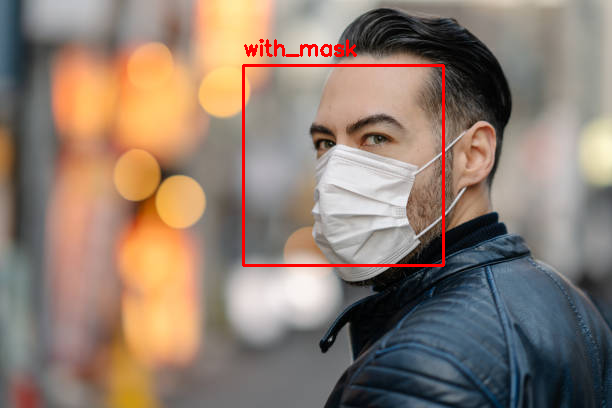

In [137]:
test_image_path = input('Path of the image to be predicted: ')
output_frame = predict_mask_on_image(test_image_path, face_cascade, model, class_names)

# Display the final image
if output_frame is not None:
    print("Displaying result:")
    cv2_imshow(output_frame)